# Dog Breed Classifier Project

## 3. Applying transfer learning for better predictions

We will now fine-tune the pretrained ResNet-50 model to our specific task, which is identifying dog breeds including the Korean Jindo dog.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from collections import Counter
import cv2
from PIL import ImageFile
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import os.path
import math
import pickle

In [2]:
# Paths to the training, validation and test datasets
TRAINING_DATA_DIR = 'images/train/'
VALIDATION_DATA_DIR = 'images/valid/'
TEST_DATA_DIR = 'images/test/'

Let's see how many pictures we have in our datasets.

In [3]:
TRAIN_SAMPLES = sum([len(filenames) for dirpath, dirnames, filenames in os.walk(TRAINING_DATA_DIR)])
VALIDATION_SAMPLES = sum([len(filenames) for dirpath, dirnames, filenames in os.walk(VALIDATION_DATA_DIR)])
TEST_SAMPLES = sum([len(filenames) for dirpath, dirnames, filenames in os.walk(TEST_DATA_DIR)])

print("Number of training samples : {}".format(TRAIN_SAMPLES))
print("Number of validation samples : {}".format(VALIDATION_SAMPLES))
print("Number of test samples : {}".format(TEST_SAMPLES))

Number of training samples : 6787
Number of validation samples : 845
Number of test samples : 846


How many classes (dog breeds) do we have?

In [4]:
NUM_CLASSES = len(next(os.walk(TRAINING_DATA_DIR))[1])

print("Number of classes: {}".format(NUM_CLASSES))

Number of classes: 134


A few general parameters for the model.  
- Image size : Size of images that will be fed to the network. ResNet-50 model takes an input size of (224x224).  
- Batch size : Number of samples (pictures) to be processed in one iteration. Increasing the batch size speeds us training, but requires more RAM.

In [5]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 16

Keras's ImageDataGenerator class generates batches of tensor image data with real-time data augmentation.  
Data augmentation allows to get more training data by applying different transformations to the existing pictures (rotation, shift, zoom, etc.).  
Data augmentation should only be applied to training pictures.

In [6]:
# Set PIL to allow image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ImageDataGenerator for training pictures with data augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

# ImageDataGenerator for validation pictures (will also be used for test pictures)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Load pictures from their directories. Each directory corresponds to one dog breed.  
Classes (labels) are automatically created according to the name of the folder in which pictures are stored.

In [7]:
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True, # Training pictures are shuffled to introduce more randomness during the training process
                                                    seed=42,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(VALIDATION_DATA_DIR,
                                                       target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False,
                                                       class_mode='categorical')

Found 6787 images belonging to 134 classes.
Found 845 images belonging to 134 classes.


Create a dictionary that matches the class indexes (from 0 to 133) to the class names (134 dog breeds).

In [8]:
labels = (train_generator.class_indices)
labels = dict((v,k.split('.')[1]) for k,v in labels.items())

# Save the dictionnary to file for future use
pickle.dump(labels, open('./labels.pickle', 'wb'))

print(labels)

{0: 'Affenpinscher', 1: 'Afghan_hound', 2: 'Airedale_terrier', 3: 'Akita', 4: 'Alaskan_malamute', 5: 'American_eskimo_dog', 6: 'American_foxhound', 7: 'American_staffordshire_terrier', 8: 'American_water_spaniel', 9: 'Anatolian_shepherd_dog', 10: 'Australian_cattle_dog', 11: 'Australian_shepherd', 12: 'Australian_terrier', 13: 'Basenji', 14: 'Basset_hound', 15: 'Beagle', 16: 'Bearded_collie', 17: 'Beauceron', 18: 'Bedlington_terrier', 19: 'Belgian_malinois', 20: 'Belgian_sheepdog', 21: 'Belgian_tervuren', 22: 'Bernese_mountain_dog', 23: 'Bichon_frise', 24: 'Black_and_tan_coonhound', 25: 'Black_russian_terrier', 26: 'Bloodhound', 27: 'Bluetick_coonhound', 28: 'Border_collie', 29: 'Border_terrier', 30: 'Borzoi', 31: 'Boston_terrier', 32: 'Bouvier_des_flandres', 33: 'Boxer', 34: 'Boykin_spaniel', 35: 'Briard', 36: 'Brittany', 37: 'Brussels_griffon', 38: 'Bull_terrier', 39: 'Bulldog', 40: 'Bullmastiff', 41: 'Cairn_terrier', 42: 'Canaan_dog', 43: 'Cane_corso', 44: 'Cardigan_welsh_corgi', 45

Plot the number of training images for each class.

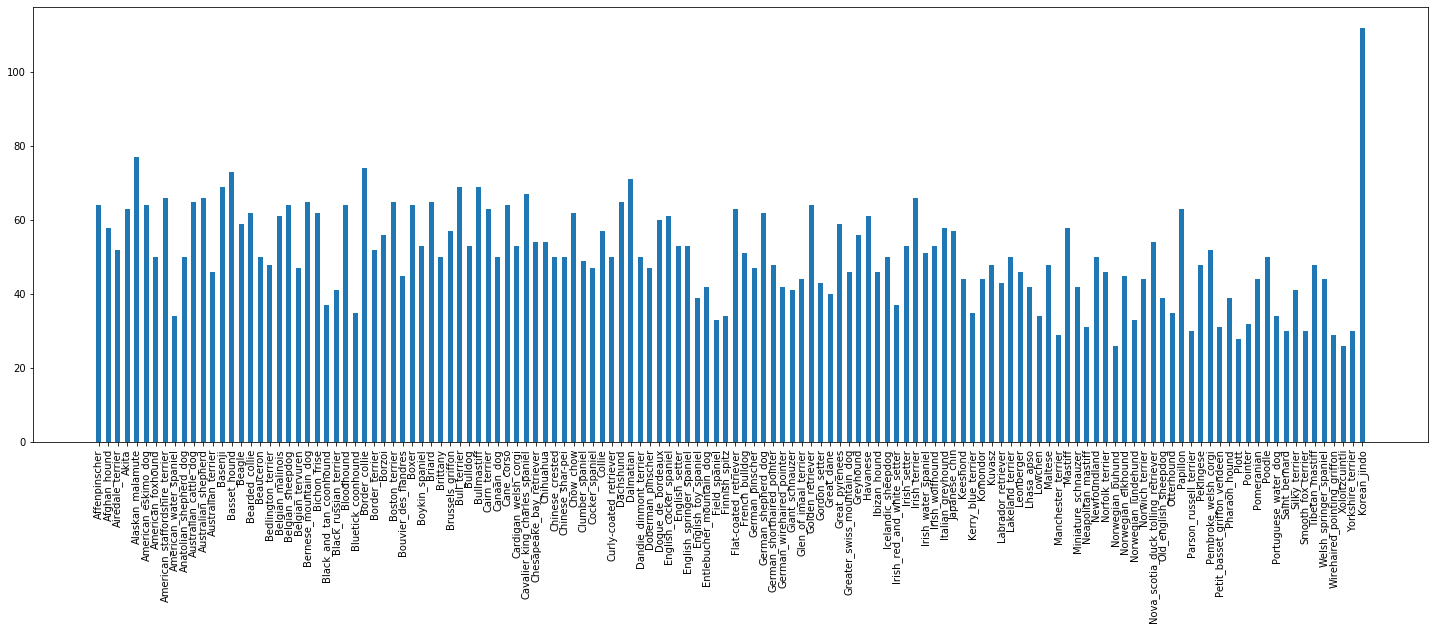

In [9]:
_, values = zip(*Counter(train_generator.labels).items())
indexes = np.arange(len(labels.values()))

plt.figure(figsize=(25,8))
plt.bar(indexes, values, 0.5)
plt.xticks(indexes, labels.values(), rotation='vertical')

plt.show()

Import the pretrained ResNet50 model and modify its composition for transfer learning.

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, GlobalAveragePooling2D, Dense, Dropout, Flatten

# Import the pretrained model without the top classification layer
base_model = ResNet50(include_top=False,
                      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze all layers except for the last 8 layers that will be retrained
for layer in base_model.layers[:-8]:
    layer.trainable = False

custom_model = GlobalAveragePooling2D()(base_model.output)
custom_model = Dense(512, activation='relu')(custom_model)
custom_model = Dropout(0.5)(custom_model)

# Final layer : the number of neurons is equal to the number of classes we want to predict
# Since we have more than two classes, we choose 'softmax' as the activation function.
custom_model = Dense(NUM_CLASSES, activation = 'softmax')(custom_model)

model = Model(inputs=base_model.input, outputs=custom_model)

Visualize the layers in our model.

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Compile and fit the model on the training generator.  
Validation data allows to evaluate the performance of the model at each epoch.  
Since we have more than two classes, we choose 'categorical_crossentropy' as the loss function.

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])

model.fit_generator(train_generator,
                    steps_per_epoch = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
                    validation_data = validation_generator,
                    validation_steps = math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE),
                    epochs=25)

Epoch 1/25
425/425 [==============================] - 179s 421ms/step - loss: 3.2947 - acc: 0.2530 - val_loss: 1.3830 - val_acc: 0.5953
Epoch 2/25
425/425 [==============================] - 178s 418ms/step - loss: 1.8840 - acc: 0.4792 - val_loss: 1.1561 - val_acc: 0.6615
Epoch 3/25
425/425 [==============================] - 178s 418ms/step - loss: 1.4522 - acc: 0.5746 - val_loss: 1.2121 - val_acc: 0.6651
Epoch 4/25
425/425 [==============================] - 177s 417ms/step - loss: 1.2696 - acc: 0.6246 - val_loss: 0.8637 - val_acc: 0.7325
Epoch 5/25
425/425 [==============================] - 324s 763ms/step - loss: 1.1307 - acc: 0.6582 - val_loss: 0.9951 - val_acc: 0.7148
Epoch 6/25
425/425 [==============================] - 329s 773ms/step - loss: 1.0386 - acc: 0.6910 - val_loss: 0.8014 - val_acc: 0.7633
Epoch 7/25
425/425 [==============================] - 332s 782ms/step - loss: 0.9530 - acc: 0.7081 - val_loss: 0.9054 - val_acc: 0.7456
Epoch 8/25
425/425 [============================

Save the model so we don't have to train it again. Calling the method 'save()' allows to keep:
- The architecture of the model, allowing to re-create the model
- The weights of the model
- The training configuration (loss, optimizer)
- The state of the optimizer, allowing to resume training exactly where you left off.

In [24]:
# Save the model to Keras HDF5 format
model.save('./model-finetuned.h5', save_format='h5')
           
# Save the model to TensorFlow format (for deployment to Google AI Platform)
model.save('TFSavedModel', save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: TFSavedModel\assets


In [17]:
# Load the saved model
model = load_model('./model-finetuned.h5')

### Accuracy

Before going further, let's see if the model actually learnt to recognize the Korean Jindo dog.

In [13]:
files = list() # List of files retrieved from the directory
top_predictions = []

# Go through Jindo dog images in the training dataset
for (dirpath, dirnames, filenames) in os.walk('images/train/134.Korean_jindo'):
    files += [os.path.join(dirpath, file) for file in filenames]

# Pre-process each image and feed it to the model to get a prediction
for i in files:
    # Transform each image into a Tensor
    img = image.load_img(i, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    
    # Get predictions from the model    
    prediction = model.predict(img_preprocessed)
    
    # Get index of prediction with the highest probability
    top_index = np.argmax(prediction)
    top_predictions.append(labels[top_index])

In [14]:
from collections import Counter
Counter(top_predictions).most_common()

[('Korean_jindo', 103),
 ('Akita', 3),
 ('Kuvasz', 2),
 ('Canaan_dog', 1),
 ('American_eskimo_dog', 1),
 ('Belgian_sheepdog', 1),
 ('Australian_cattle_dog', 1)]

That is quite reassuring. Most pictures of Jindo dogs in the training dataset were guessed correctly.  
But that is not very surprising, since we trained the model on that same training set, and the model adapted its weights to recognize those pictures.  
Let's now evaluate the model more objectively, using the validation and test sets.

In [15]:
score = model.evaluate_generator(validation_generator, math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))
print("Validation accuracy : {:.2f} %".format(score[1]*100))

Validation accuracy : 81.54 %


Accuracy = number of correct predictions / number of total predictions  
  
Near 82 % accuracy is not so bad given the small number of pictures we had for each breed.  
What about accuracy on the test set, which has not been seen at all by the model?

In [16]:
# Load images from the test directory
test_generator = val_datagen.flow_from_directory(TEST_DATA_DIR,
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 846 images belonging to 134 classes.


In [17]:
score = model.evaluate_generator(test_generator, math.ceil(float(TEST_SAMPLES) / BATCH_SIZE))
print("Test accuracy : {:.2f} %".format(score[1]*100))

Test accuracy : 79.20 %


As expected, test accuracy is a bit lower than validation accuracy.

### Confusion matrix & Classification report

Let's compute a few more evaluation metrics on the test set, with the help of confusion matrix and classification report.  
- A confusion matrix is a summary of prediction results on a classification problem: it shows how many samples were correctly guessed for each class (the diagonal of the matrix), and the misclassified samples.
- A classification report shows the main classification metrics (precision, recall, F1 score) for each class.

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the test dataset
predictions = model.predict_generator(test_generator, math.ceil(float(TEST_SAMPLES) / BATCH_SIZE))

# Get the list of top predictions (index of class with highest probability) for all images
top_index = np.argmax(predictions, axis=1)

# Compute the confusion matrix: the horizontal axis shows the predicted classes, the vertical axis shows the actual class
matrix = confusion_matrix(test_generator.classes, top_index)

In [19]:
matrix

array([[6, 0, 0, ..., 0, 0, 0],
       [0, 6, 0, ..., 0, 0, 0],
       [0, 0, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 7]], dtype=int64)

The confusion matrix is too large to be displayed entirely here. We will slice it and make it more visually pleasant.  
Before that, let's take a look at the 133th column of the matrix, which shows the number of images from each class (from 0 to 133) that were classified as class no. 133 (Jindo dog).

In [20]:
print(matrix[:,133])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]


Out of 9 pictures that were classified by the model as Jindo dogs, 7 are actually Jindo dogs (they are from class 133).  
Now let's look at the 133th line of the matrix, showing how the 10 pictures of Jindo dogs in our dataset were classified by the model.

In [21]:
print(matrix[133])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]


Out of the 10 pictures, 7 were correctly classified as Jindo dogs, 1 misclassified as Akita dog, 1 as Canaan dog, and 1 as Norwegian buhund. All are from the same 'spitz' family.

 
Let's slice the matrix and display it more nicely using the Seaborn library.

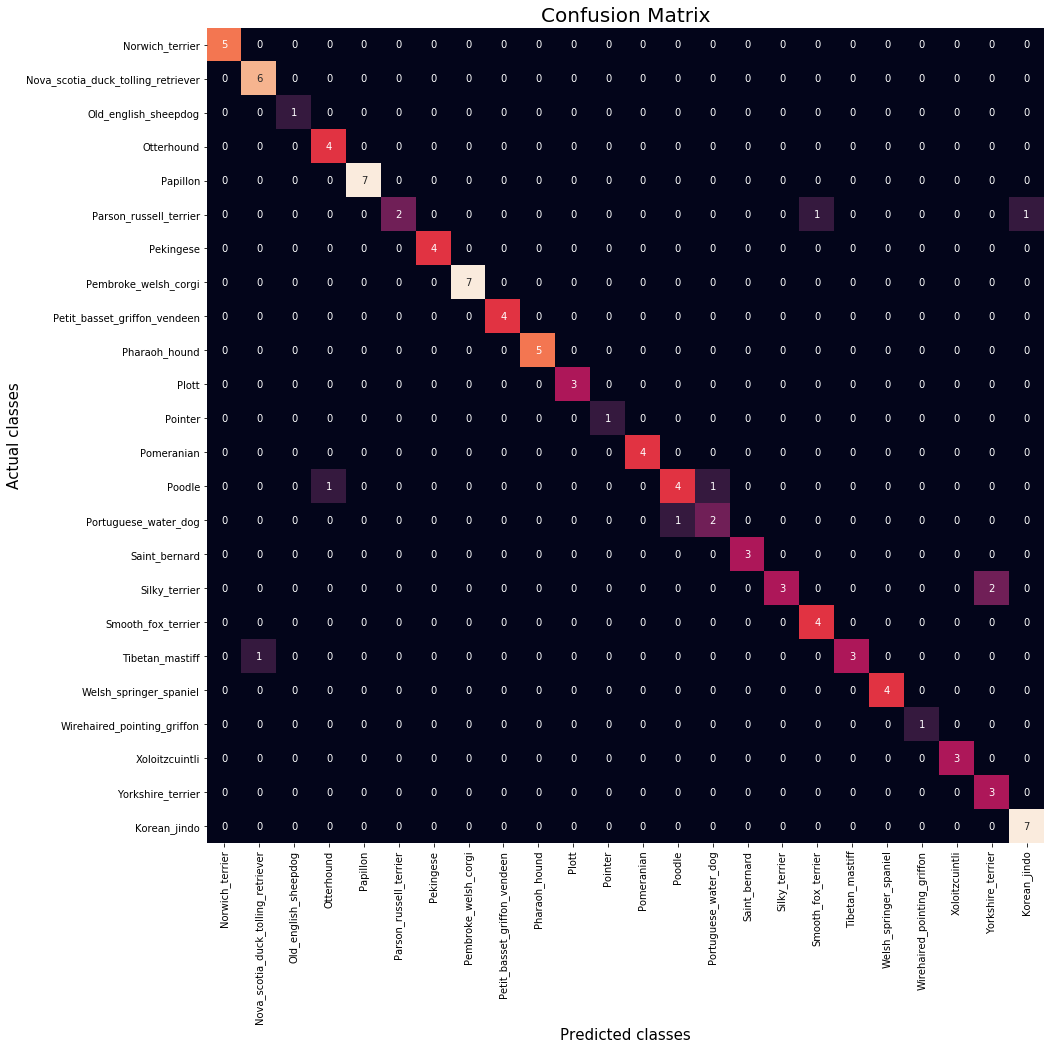

In [22]:
import pandas as pd
import seaborn as sns

# Build a Pandas dataframe with the confusion matrix as values and the classes as row/column names
df_matrix = pd.DataFrame(matrix, index=labels.values(), columns=labels.values())

# Plot a slice of the confusion matrix (the last 24 classes only)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_matrix.iloc[110:,110:], annot=True, cbar=False, ax=ax)

plt.title('Confusion Matrix', fontsize = 20)
plt.xlabel('Predicted classes', fontsize = 15)
plt.ylabel('Actual classes', fontsize = 15)
plt.show()

We can verify that 7 Jindo dog pictures (out of a total of 10) were correctly classified (in the lower-right corner of the matrix).
We can also see that one picture of a Parson russel terrier was misclassified as a Korean Jindo.
  
And now, the classification report which shows:
- Precision : Number of positive class predictions that actually belong to the positive class (What proportion of positive class predictions was actually correct?)  
  Precision = True positives / (True positives + False positives)  
   
- Recall : Number of positive class predictions made out of all positive examples in the dataset (What proportion of actual positives was identified correctly?)  
  Recall = True positives / (True positives + False negatives)  
   
- F1-score : Weighted average of precision and recall  
  F1-score = 2*(Recall * Precision) / (Recall + Precision)

In [23]:
print('Classification Report')
print(classification_report(test_generator.classes, top_index, target_names=labels.values()))

Classification Report
                                    precision    recall  f1-score   support

                     Affenpinscher       1.00      0.75      0.86         8
                      Afghan_hound       0.75      0.75      0.75         8
                  Airedale_terrier       0.75      1.00      0.86         6
                             Akita       0.88      0.88      0.88         8
                  Alaskan_malamute       0.90      0.90      0.90        10
               American_eskimo_dog       0.88      0.88      0.88         8
                 American_foxhound       1.00      0.43      0.60         7
    American_staffordshire_terrier       0.89      1.00      0.94         8
            American_water_spaniel       1.00      0.25      0.40         4
            Anatolian_shepherd_dog       0.80      0.67      0.73         6
             Australian_cattle_dog       1.00      1.00      1.00         9
               Australian_shepherd       1.00      0.89      0.94

Looking at the last class (Korean Jindo dog), we got a precision of 0.78 and a recall of 0.70. That means :  
- 78 % of dogs that were classified as Jindo dogs are actually Jindo dogs. The remaining 22 % were mistaken for Jindo dogs.
- 70 % of all Jindo dogs were correctly classified as Jindo dogs (that is 7 pictures out of 10, since we had 10 pictures of Jindo dogs in the test set).  

### Vizualise the predictions

Let's visualize the predictions along with the pictures.

In [31]:
# Function to randomly select, pre-process pictures from a PATH and run the model to make predictions on those pictures
def pick_pictures(path, columns, rows):
    # Create a matplotlib figure
    fig=plt.figure(figsize=(20, 12))
    ax = []
    
    # Browse files in the PATH directory
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(path):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    
    # Randomly pick a certain number of pictures from the list
    files = random.sample(range(len(listOfFiles)), columns*rows)
    
    for i in range(columns*rows):
        # Transform each image into a Tensor
        img = image.load_img(listOfFiles[files[i]], target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        
        # Get predictions from the model
        prediction = model.predict(img_preprocessed)
        
        # Retrieve the label and probability for the top two guesses
        first_index = prediction.argsort()[0][-2:][1]
        second_index = prediction.argsort()[0][-2:][0]
        
        # Plot the results in an ordered fashion
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title("Probably a {}".format(labels[first_index]) +
                         "\n({:.2f} % chance)".format(prediction[0][first_index]*100) +
                         "\n\nPossibly a {}".format(labels[second_index]) +
                         "\n({:.2f} % chance)".format(prediction[0][second_index]*100) +
                         "\n\nGround truth: {}".format(listOfFiles[files[i]].split("/")[2].split(".")[1].split("\\")[0])
                        )
        
        plt.axis('off')
        plt.imshow(img)

Let's take a look at Jindo dogs first:

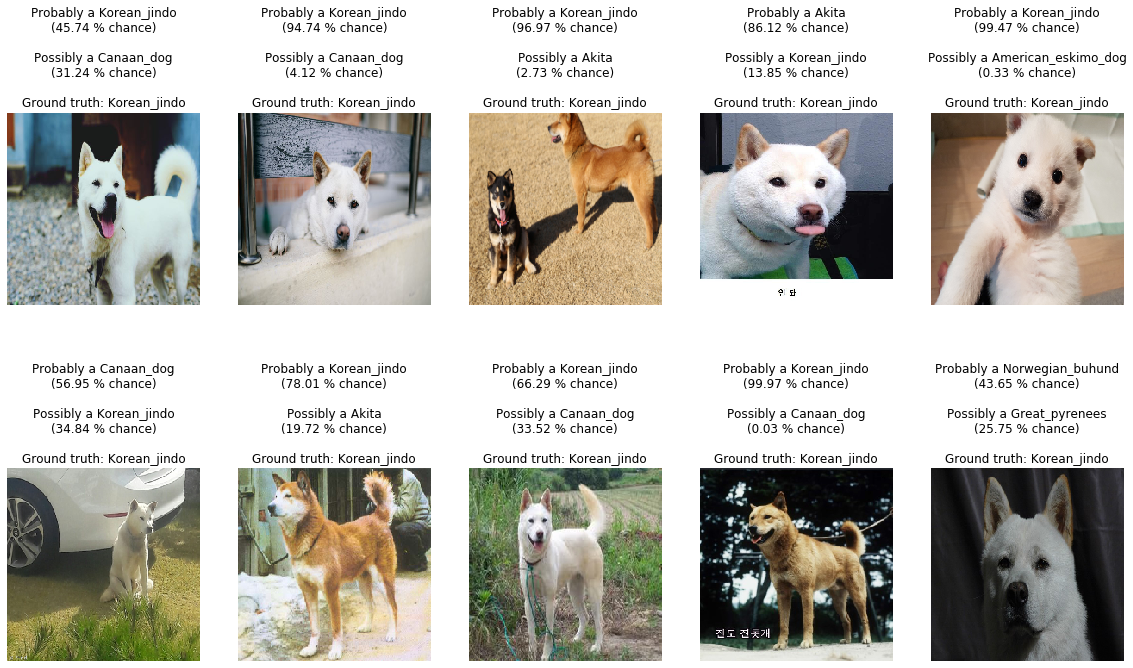

In [29]:
PATH = 'images/test/134.Korean_jindo'

COLUMNS = 5
ROWS = 2

pick_pictures(PATH, COLUMNS, ROWS)

As we already knew by looking at the confusion matrix, 7 of the 10 Jindo pictures were correctly classified.  
For 2 of the rest, Jindo comes as the second guess.   
1 picture has been mis-classified as a Norwegian Buhund (top guess) and Great Pyrenees (2nd guess).
  
Let's look at some more pictures of other breeds from our test set:

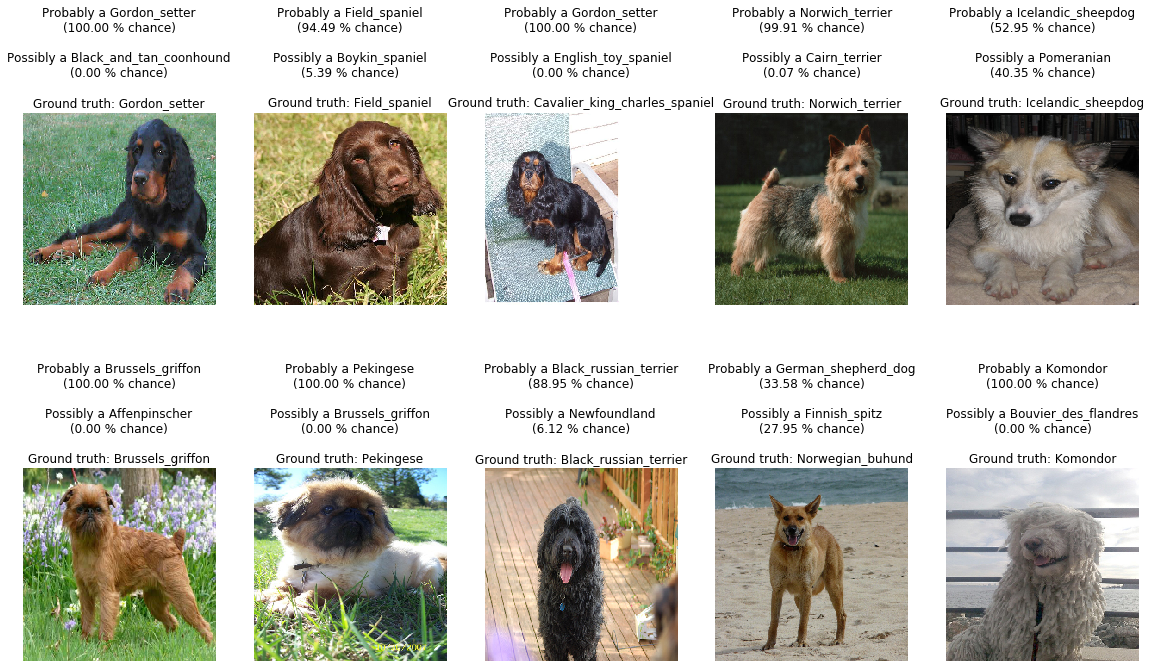

In [32]:
PATH = 'images/test/'

COLUMNS = 5
ROWS = 2

pick_pictures(PATH, COLUMNS, ROWS)

Finally, let's look at the important regions in an image for the neural network to make a prediction.  
Grad-CAM relies on the gradients flowing into the final convolutional layer of the CNN to produce a map highlighting the important regions in the image for predicting the correct class.

In [36]:
# Function to compute and display Grad CAM on an image file passed as parameter along with its groud truth class and the name of the last convolutional layer of the model
def grad_cam(path, class_index, layer):

    img = image.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_arr = image.img_to_array(img)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_arr]))
        loss = predictions[:, class_index]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    output_image = cv2.addWeighted(cv2.cvtColor(img_arr.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

    fig=plt.figure(figsize=(10, 10))
    
    ax = []
    
    # Display original image
    ax.append(fig.add_subplot(1, 2, 1))
    ax[-1].set_title("Original Image")
    plt.imshow(img)
    plt.axis('off')
    
    # Display Grad CAM
    ax.append(fig.add_subplot(1, 2, 2))
    ax[-1].set_title("Grad CAM")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

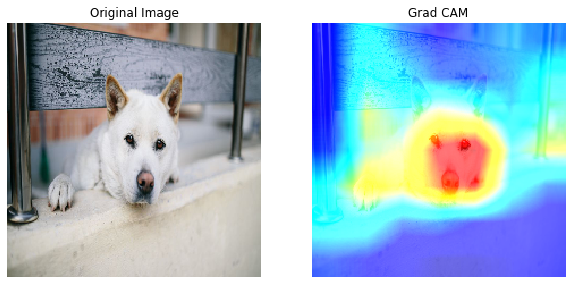

In [37]:
IMAGE_PATH = 'images/test/134.Korean_jindo/23.KoreanJindo_GettyImages-498986141-f3e7d4a159ae451283928acdbae0e85d.jpg' # Path of the image file
LAYER_NAME = 'conv5_block3_out' # Name of the last convolutional layer of the CNN model
CLASS_IDX = 133 # Index of the class corresponding to the image

grad_cam(IMAGE_PATH, CLASS_IDX, LAYER_NAME)

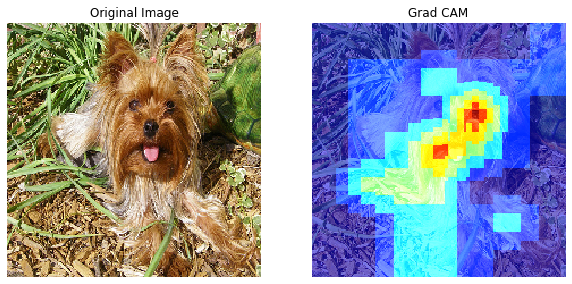

In [38]:
IMAGE_PATH = 'images/test/133.Yorkshire_terrier/Yorkshire_terrier_08325.jpg' # Path of the image file
LAYER_NAME = 'conv5_block3_out' # Name of the last convolutional layer of the CNN model
CLASS_IDX = 132 # Index of the class corresponding to the image

grad_cam(IMAGE_PATH, CLASS_IDX, LAYER_NAME)

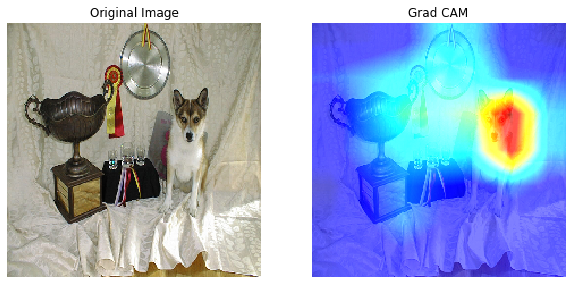

In [39]:
IMAGE_PATH = 'images/test/110.Norwegian_lundehund/Norwegian_lundehund_07222.jpg' # Path of the image file
LAYER_NAME = 'conv5_block3_out' # Name of the last convolutional layer of the CNN model
CLASS_IDX = 109 # Index of the class corresponding to the image

grad_cam(IMAGE_PATH, CLASS_IDX, LAYER_NAME)

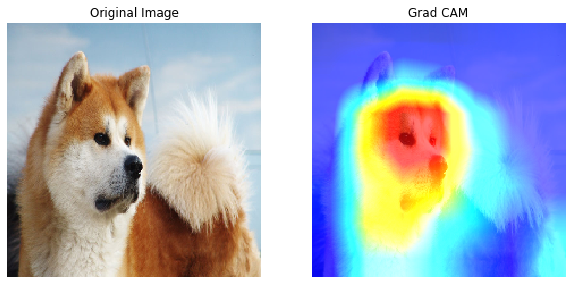

In [40]:
IMAGE_PATH = 'images/test/004.Akita/Akita_00263.jpg' # Path of the image file
LAYER_NAME = 'conv5_block3_out' # Name of the last convolutional layer of the CNN model
CLASS_IDX = 3 # Index of the class corresponding to the image

grad_cam(IMAGE_PATH, CLASS_IDX, LAYER_NAME)